## Optimizing the distance function

1
4
21
100
464
2154
10000
46415
215443
1000000


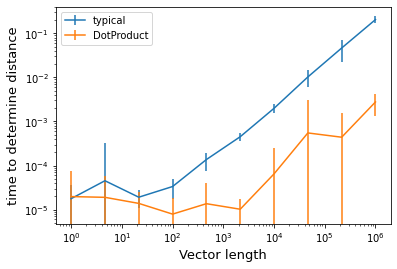

In [445]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def distance_between_vectors_euclidean_dotProduct(a,b):
    return np.sqrt(np.dot(a-b,a-b))


def distance_between_vectors_euclidean_typical(a,b):
    return np.sqrt(sum((a-b)**2) )
    


methods = [distance_between_vectors_euclidean_typical, 
           distance_between_vectors_euclidean_dotProduct]

data = {}
sizes=np.logspace(0,5,10)
for size in sizes:
    size = int(size)
    print(size)
    times = [[],[]]
    for _ in range(100):
        a, b = np.random.rand(size), np.random.rand(size)
        for index, func in enumerate(methods):
            start_time = time.time()
            func(a,b)
            end_time = time.time()
            delta_time = end_time - start_time
            times[index].append(delta_time)
            
    means = np.mean(times,axis = 1)
    stds = np.std(times,axis = 1)
    data[size] = {'time':
                  {'Typical' : means[0],
                  'Dotproduct': means[1]},
                  'std' : 
                  {'Typical' : stds[0],
                  'Dotproduct': stds[1]}}
dict_of_df = {k: pd.DataFrame(v) for k,v in data.items()}
df = pd.concat(dict_of_df, axis=1).T.reset_index()
df.head()

time_typical = df[df['level_1']=='time']['Typical'].values
time_Dotproduct = df[df['level_1']=='time']['Dotproduct'].values

std_typical = df[df['level_1']=='std']['Typical'].values
std_Dotproduct = df[df['level_1']=='std']['Dotproduct'].values

plt.errorbar(sizes, time_typical, yerr= std_typical, label='typical')
plt.errorbar(sizes, time_Dotproduct, yerr= std_Dotproduct, label = 'DotProduct')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Vector length', fontsize=13)
plt.ylabel('time to determine distance', fontsize=13)
plt.show()

In the first cell, we show that distance via dotProduct is approx. 2x faster than typical method

In [540]:
# Does this work for a matrix?
size = 4
A = np.random.rand(size,size)
A

array([[0.9602066 , 0.92045173, 0.42194045, 0.19024539],
       [0.78676983, 0.90269627, 0.30923476, 0.08826231],
       [0.86000916, 0.79796547, 0.04651082, 0.76277399],
       [0.10507158, 0.82342387, 0.5851971 , 0.52359169]])

In [541]:
nn2_new(A)

[2 3 0 1]
[0.5  0.25 1.   0.75]
[0.25 0.   0.75 0.5 ]


(1.2971769386924235, 0.4135697166618778)

In [544]:
from scipy.stats import chisquare

def nn2_new(A):
    N  = len(A)
    #Make distance matrix
    dist_M = np.array([[distance_between_vectors_euclidean_dotProduct(a,b) if index0 < index1 else 0 for index1, b in enumerate(A)] for index0, a in enumerate(A)])
    dist_M += dist_M.T + np.eye(N)*42
    
    # Calculate mu
    argsorted = np.sort(dist_M, axis=1)
    mu =  argsorted[:,1]/argsorted[:,0]
    x = np.log(mu)
    
    # Permutation
    y = np.array([1-dict(zip(np.argsort(mu),(np.arange(1,N+1)/N)))[i] for i in range(N)])
    
    print(y)
    # Drop bad values (negative y's)
    x,y  = x[y>0], y[y>0]
    y = -1*np.log(y)
    
    #fit line through origin to get the dimension
    d = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]
    
    # Goodness
    _, pvalue = chisquare(f_obs=x*d , f_exp=y, ddof=1)
    
    return d, pvalue

y = -\log(1-[k/N for k in ])

In [545]:
nn2(A)

[0.25 0.   0.75 0.5 ]


1.2971769386924235

In [546]:
def nn2(data, plot=False, return_xy = False,eps=.00, xshift=False, del_vals=2):
    '''
    Find intrinsic dimension (ID) via 2-nearest-neighbours

    https://www.nature.com/articles/s41598-017-11873-y
    https://arxiv.org/pdf/2006.12953.pdf
    _______________
    Parameters:
        eigvecs
        plot : create a plot; boolean; dafault=False
    _______________
    Returns:
        m : Slope
    
    '''

    N = len(data)
    
    distance_matrix = np.zeros((N, N))
    # Making the distance matrix: distance from each eigvec to all others
    for i, eigvec1 in enumerate(data):
        for j, eigvec2 in enumerate(data):
            if j <= i:
                pass
            else:
                distance = np.sum((eigvec1-eigvec2)**2)**.5
                distance_matrix[i,j], distance_matrix[j,i] = distance, distance
    #print(distance_matrix) # To see how it fills √

    # table of distances - state and \mu= r_2/r_1
    mu = np.zeros((N,2))
    for index, line in enumerate(distance_matrix):
        r1, r2 = sorted(line)[1:3]
        mu[index,0] = index+1
        mu[index,1] = r2/(r1+eps)
    if xshift == True:
        mu[:,1] -= min(mu[:,1])+1
    #print('mu:',mu)
        
    #permutation function
    
    #print(1,range(1,len(mu)+1))
    #print(2,np.array(sorted(mu, key=lambda x: x[1])))
    #print(3,dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int))))
    
    
    sigma_i = dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))
    mu = dict(mu)
    #cdf F(mu_{sigma(i)})
    F_i = {}
    for i in mu:
        F_i[sigma_i[i]] = i/N
        
    #print(F_i)

    #fitting coordinates
    x = np.log([mu[i] for i in sorted(mu.keys())])
    y = np.array([1-F_i[i] for i in sorted(mu.keys())])
    print(y)
    #avoid having log(0)
    x = x[y>0]
    y = y[y>0]
    

	

    y = -1*np.log(y)
    #y2 = -1*np.log(y2)
	
    #fit line through origin to get the dimension
    d = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]

    if plot==True:
        #fig, ax = plt.subplots(2,1, sharex=True)
        plt.scatter(x,y, c='g')
        plt.plot(x,x*d, c='r', ls='--')
        
      #ax[plot_index].set_xlabel('log($\mu$)', fontsize=12)
        #plt.text(0,5,'w={}'.format(w), fontsize=13)
        #plt.text(0,4.5,'d={}'.format(round(d,3)), fontsize=13)
        
            
    if return_xy:
        return x,y, d#,x2,y2
    else:
        return d

In [500]:
# Now lets compare these two models:

sizes = np.logspace(1,2.2,10)

times = [[],[]]

for size in sizes:
    size=int(size)
    print(size)
    for _ in range(20):
        M = np.random.rand(size,size)
        start_time = time.time()
        d = nn2(M)
        end_time = time.time()
        delta_time = end_time - start_time
        times[0].append(delta_time)
        
        start_time = time.time()
        d = nn2_new(M)
        end_time = time.time()
        delta_time = end_time - start_time
        times[1].append(delta_time)
        
times = np.array(times).reshape(2,len(sizes), 20)

10
13
18
25
34
46
63
85
116
158


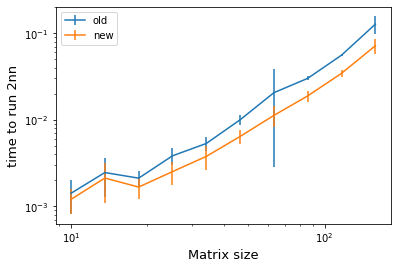

In [501]:
plt.errorbar(sizes, np.mean(times[0], axis=1), yerr=np.std(times[0], axis=1), label = 'old')
plt.errorbar(sizes, np.mean(times[1], axis=1), yerr=np.std(times[1], axis=1), label = 'new')
plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.xlabel('Matrix size', fontsize=13)
plt.ylabel('time to run 2nn', fontsize=13)
plt.show()